In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
base_dir = r"C:\Users\moham\OneDrive\Desktop\chest_xray_56\chest_xray"  # Change this to your actual path


In [3]:
# Check class distribution
for folder in ['train', 'val', 'test']:
    print(f"\n--- {folder.upper()} ---")
    for category in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(base_dir, folder, category)
        print(f"{category}: {len(os.listdir(path))} images")



--- TRAIN ---
NORMAL: 51 images
PNEUMONIA: 51 images

--- VAL ---
NORMAL: 9 images
PNEUMONIA: 9 images

--- TEST ---
NORMAL: 50 images
PNEUMONIA: 51 images


UnidentifiedImageError: cannot identify image file 'C:\\Users\\moham\\OneDrive\\Desktop\\chest_xray_56\\chest_xray\\train\\PNEUMONIA\\.DS_Store'

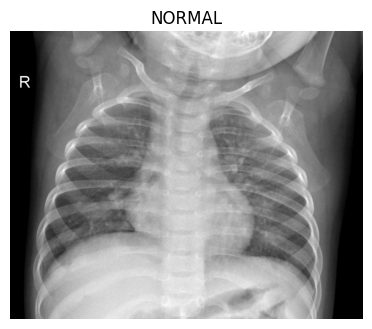

In [4]:
import random
import matplotlib.image as mpimg

def show_samples(subset):
    categories = ['NORMAL', 'PNEUMONIA']
    plt.figure(figsize=(10, 5))
    for i, label in enumerate(categories):
        folder = os.path.join(base_dir, subset, label)
        img_file = random.choice(os.listdir(folder))
        img = mpimg.imread(os.path.join(folder, img_file))
        plt.subplot(1, 2, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

show_samples("train")


datapreprocessing

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)


In [ ]:
# Create actual generators from directories
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


CNN

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Change here: use the actual variable name for your training set
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_generator.classes   # <-- FIXED here
)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("⚖️ Class Weights:", class_weights_dict)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict
)


Accuracy and loss plots

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
preds = model.predict(test_generator)                # ✅ FIXED
pred_classes = (preds > 0.5).astype("int32").flatten()
true_classes = test_generator.classes                # ✅ FIXED
labels = list(test_generator.class_indices.keys())   # ✅ FIXED


print(classification_report(true_classes, pred_classes, target_names=labels))

cm = confusion_matrix(true_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save("pneumonia_detection_model.h5")


predicting

In [ ]:

from tkinter import filedialog
from PIL import Image
import tkinter as tk

# Open a file dialog to select image
root = tk.Tk()

root.withdraw()  # Hide the root window
file_path = filedialog.askopenfilename()
print("Selected image:", file_path)



In [ ]:
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img = image.load_img(file_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
label = "PNEUMONIA" if prediction[0][0] > 0.5 else "NORMAL"

# Show result
plt.imshow(img)
plt.title(f"Prediction: {label}")
plt.axis('off')
plt.show()



In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")


In [ ]:
print(f"✅ Avg Confidence: {np.mean(model.predict(test_generator)) * 100:.2f}%")
